<a id="top"></a>
##  Water Extent Time Series
This notebook produces a time series plot of water extent. In order to avoid cloud contamination issues, the data is screened using a cloud cover threshold. This threshold can be determined using the "DCAL_Cloud_Statistics" notebook to review a given region and time period to find nearly cloud-free scenes that will allow a complete view of a water body to calculate time series water extent. The notebook also includes a "denoising" filter to remove small areas of water such as small ponds or temporary small flooded areas. The intent of the notebook is to concentrate on larger water bodies with non-isolated water pixels.

What does this Notebook do?

* [Setup the Environment](#environment_setup)
* [Explore the Data](#explore_data)
* [Retrieve the Data and Perform a Water Classification Analysis](#water_classifier)
* [Create Water Extent Image](#water_extent_image)
* [Create a Time Series Plot of the Water](#time_series_water)
* [Contributors, Heritage and References](#contributors_heritage)

This notebook uses external functions including both a standard set of DCAL utilities (see folder [DCAL_utils](../DCAL_utils)) and a code behind file containing some specalised functions that make this page work (see file [Water_Extent_Time_Series.py](Water_Extent_Time_Series.py)).

<i><p style="color:red"><b>Red Text:</b> Indicates code blocks where user inputs can be provided.</p></i>

<a id="environment_setup"></a>
## Environment Setup [&#9652;](#top)
* **Surpress Python Warnings:** These warnings include notes about deprecitation of Python modules, etc.
* **Import Standard Python Modules:** Import external and standard Python modules including `datacube` which is part of the ODC framework, as well as `xarray` which is a useful external module.
* **Import DCAL Utilities:** Import a set of utilities developed by the DCAL team to help automate some of the more routine tasks in the notebooks. These utilities are located in `/DCAL_utils`.
* **Initialize Data Cube and Data Cube API**

[Back to Top](#top)

In [1]:
# Supress Python Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Required Standard Python Modules
import datacube
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
from xarray.ufuncs import isnan as xr_nan

In [3]:
# Import notebook code behind (as cb) contaning function definitions specific to this notebook
import Water_Extent_Time_Series as cb

# Import DCAL utilities containing function definitions used generally across DCAL
# Add DCAL_utils to the sys.path
sys.path.append('..')

# Import Data Cube API
import DCAL_utils.data_access_api as dc_api

# Import overlapping area function
from DCAL_utils.dc_load import get_overlapping_area

# Import date time to string function
from DCAL_utils.dc_time import dt_to_str

# Import display map function
from DCAL_utils.dc_display_map import display_map

# Import wofs classifier
from DCAL_utils.dc_water_classifier import wofs_classify

# Import warnings function
from DCAL_utils.dc_utilities import ignore_warnings

# Import figure ration function
from DCAL_utils.plotter_utils import figure_ratio

# Import set axes function
from DCAL_utils.plotter_utils import xarray_set_axes_labels

# Import time by bin function
from DCAL_utils.aggregate import xr_sel_time_by_bin

# Import converter function
from DCAL_utils.plotter_utils import np_dt64_to_str

# Import SPECIAL object filter function
from DCAL_utils_special.raster_filter import lone_object_filter

# Import SPEICAL binary plot function
from DCAL_utils_special.plotter_utils import binary_class_change_plot

# Import SPECIAL time series plot function
from DCAL_utils_special.plotter_utils import xarray_time_series_plot

In [4]:
# Initialize Data Cube (dc)
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

# Initialize Data Cube API (dc_api)
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

<a id="explore_data"></a>
## Explore Data [&#9652;](#top)
* **Select Product:** Specify the product you desire to use. Note you can see the complete list of products in this Cube in the introductory notebook (<a href="../Open%20Data%20Cube%20Application%20Library%20Notebooks.ipynb#products" target="_blank">click here</a>).
* **View Dataset Spatial and Temporal Extents:** Queries the Cube and displays the min/max latitude and longitude, and the start and end date and time.
* **Select Spatial and Temporal Extents:** Select the area of interest (AOI) and time range based on extents available.
* **Display the Area of Interest:** Renders a map of the AOI.

<p style="color:red";><b>Select Products:</b> Select Data Cube products based on what is available. (<a href="../OpenDataCube_Application_Library_Notebooks.ipynb#products" target="_blank" style="color:red">Click here to inspect available products</a>.)</p>

[Back to Top](#top)

In [5]:
# Select the platforms (satellites) and products (datacube) for this analysis
# Product = tanzania or kenya

platforms = ['LANDSAT_8']
products = ['ls8_lasrc_tanzania']

In [6]:
# Output the available dataset region and times
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)
print("Available Latitude Extents:", full_lat)
print("Available Longitude Extents:", full_lon)
print("Available Time Extents:", np.vectorize(dt_to_str)(min_max_dates))

Available Latitude Extents: (-11.999154698723961, 0.0)
Available Longitude Extents: (28.998649001862958, 40.99820216383851)
Available Time Extents: [['2013-04-12' '2018-01-01']]


In [7]:
# Define the time extents of the analysis (Year,Month,Day)
time_extents = [dt.datetime(2014,1,1), dt.datetime(2020,1,19)]

<p style="color:red";>Specify the Lat-Lon bounds of the analysis region (`lat` and `lon`) and the clear pixel threshold (`clear_px_thresh`) as a fractional percent (e.g. 0.98 for 98%) which specifies the minimum percent of pixels in a time slice (an image) which are clear that will allow the time slice to be used in the analysis.</p>

In [8]:
# Lake Salunga, Tanzania
# lat = (-6.2936, -5.8306 ) 
# lon = (34.9943, 35.3624 ) 
# clear_px_thresh = 0.98

# Mtera Reservoir, Tanzania
lat = (-7.22, -6.80) 
lon = (35.60, 36.00) 
clear_px_thresh = 0.97

# Ndakaini Dam, Kenya 
# lat =  (-0.8270, -0.8067) 
# lon =  (36.8137, 36.8529)
# clear_px_thresh = 0.99

In [9]:
# View the analysis region on a map
display_map(lat, lon)

<a id="water_classifier"></a>
### Retrieve the Data and Perform a Water Classification Analysis [&#9652;](#top)

[Back to Top](#top)

In [10]:
# NOTE: added dc, lon, lat, clear_px_thresh to function arguments to support code behind as the function assumed these variables existed
dataset, clean_mask = cb.load_for_time_range(platforms, products, time_extents, dc, lon, lat, clear_px_thresh)

In [11]:
pd.DataFrame({'time': dataset.time.values})

,time
0,2014-02-03 07:45:48
1,2014-05-10 07:44:22
2,2014-05-26 07:44:18
3,2014-06-27 07:44:29
4,2014-07-13 07:44:38
5,2014-10-01 07:44:56
6,2014-11-18 07:44:57
7,2015-03-10 07:44:25
8,2015-06-14 07:44:03
9,2015-06-30 07:44:10


In [12]:
# Denoising Filter

# This code is used to filter the water detection results to remove small areas of 
# water such as small ponds or temporary small flooded areas. The intent of the notebook 
# is to concentrate on larger water bodies with non-isolated water pixels. 

# Select whether to denoise the data (True) or not denoise (False)

denoise = True

# Select the Denoising Parameters

# min_size > Minimum size of connected pixels that will not be filtered (minimum=2). 
# So, a value of 20 means a water body must have a minimum dimension of 20*30m = 600 meters.

# kernal_size > Diameter of the modal kernal (minimum=3). 
# Larger values will run slower as it calculates the mode of the neighborhood for each pixel inside this diameter.

# connectivity > Maximum distance between any two pixels. A value of 1 allows only contiguous regions of pixels. 

# max_num_filter_runs > Filter is run until the output stops changing or this number of runs has been performed. 

std_denoise_params = dict(min_size=200, kernel_size=19, connectivity=5)
max_num_filter_runs = 4

In [13]:
# Get WOFS classifications.
water_da = ignore_warnings(wofs_classify, dataset).wofs
water_da = water_da.where((water_da!=-9999) & clean_mask)

In [14]:
%%time

# Denoise the classifications.
if denoise:
    # Encode NaN as -1 for `lone_object_filter()`.
    water_da = water_da.where(~xr_nan(water_da), -1)
    for time in water_da.time:
        water_slice_prev = water_da.sel(time=time).values
        water_slice_new = lone_object_filter(water_slice_prev, **std_denoise_params)
        # While the filter output is still changing, keep rerunning it.
        filter_run_count = 0
        while (water_slice_new != water_slice_prev).any() and filter_run_count < max_num_filter_runs:
            water_slice_prev = water_slice_new
            water_slice_new = lone_object_filter(water_slice_prev, **std_denoise_params)
            filter_run_count += 1
        water_da.sel(time=time).values[:] = water_slice_new
    water_da = water_da.where(water_da!=-1) # Reencode -1 as NaN.
water_da = water_da == 1

CPU times: user 2min 3s, sys: 648 ms, total: 2min 4s
Wall time: 2min 4s


### <a id="water_extent_image"></a>**Create Water Extent Image** [&#9652;](#top)

[Back to Top](#top)

In [15]:
# A list of 5 colors to show which pixels are never water ('never'), 
# in the maximum water extent ('max'), in the minimum water extent ('min'), 
# sometimes or always water ('some'), and which have no data ('no_data'), in that order. 
# Can be contain names of matplotlib colors (lower-case strings like 'black' or 'yellow') and 
# RGBA color arrays (a list of 4 integers in the range [0, 255]).
colors = {'never': 'black', 'max': 'cyan', 'min': 'cyan', 'some': 'yellow', 'no_data': 'white'}

In [16]:
import matplotlib as mpl

colors = {key:([*mpl.colors.to_rgb(color), 1.] if isinstance(color,str) else color) 
          for key, color in colors.items()}

water_pcts = water_da.mean(['latitude', 'longitude']).values
water_never = water_da.max('time') == 0
water_max_ind = np.argmax(water_pcts)
water_max_date = water_da.time.values[water_max_ind]
water_max = water_da.sel(time=water_max_date) == 1
water_min_ind = np.argmin(water_pcts)
water_min_date = water_da.time.values[water_min_ind]
water_min = water_da.sel(time=water_min_date) == 1
water_some = water_da.max('time')
no_data_mask = ~clean_mask.max('time')
class_masks = {'never':water_never, 'max':water_max, 'min':water_min, 
               'some':water_some, 'no_data':no_data_mask}

labels = list(map(lambda str: str.format('Water'),
                  ['Never {}', 'Max {}', 'Min {}', 'Sometimes {}', 'No Data']))

dt64_to_date_str = lambda dt64 : pd.to_datetime(str(dt64)).strftime('%Y/%m/%d')
water_max_date_str = dt64_to_date_str(water_max_date)
water_min_date_str = dt64_to_date_str(water_min_date)

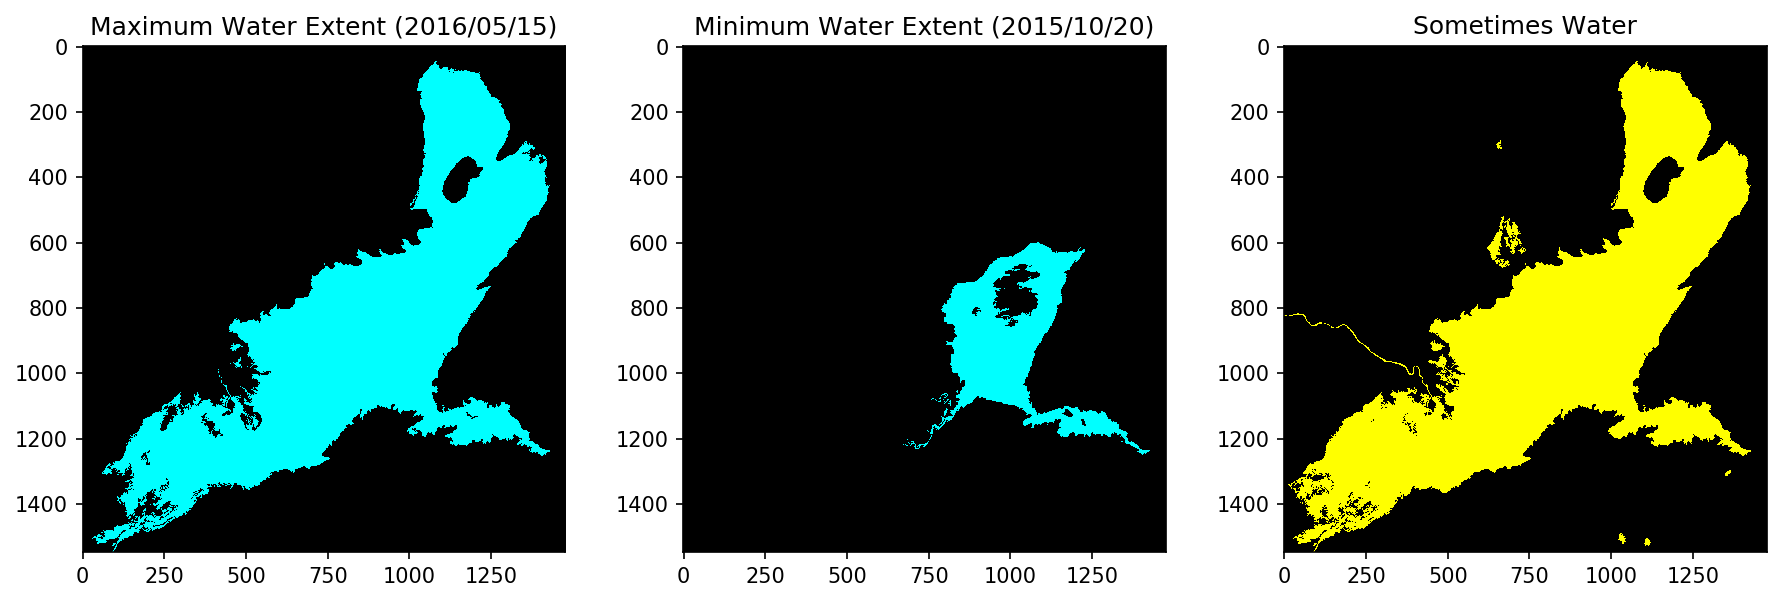

In [17]:
std_dpi = 150 # Standard image dpi.
fig_width = 4 # Use this to change the size of this figure.
num_rows, num_cols = 1, 3
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, 
                   figsize=figure_ratio(water_da, fixed_width=fig_width, 
                                        num_rows=num_rows, num_cols=num_cols), dpi=std_dpi)

# Show the max water extents, min water extents, and the pixels which are water at any time (sometimes water)

plot_titles = [f'Maximum Water Extent ({water_max_date_str})', 
               f'Minimum Water Extent ({water_min_date_str})', 
               'Sometimes Water']
for plot_ind, class_type in enumerate(['max', 'min', 'some']):
    color = colors[class_type]
    class_mask, color = class_masks[class_type], colors[class_type]
    # Create the colored image.
    color_array = np.full((len(water_da.latitude), len(water_da.longitude), 4), 1, dtype=np.uint8)
    color_array[class_mask.values] = color
    color_array[no_data_mask.values] = colors['no_data']
    color_array[~class_mask.values & ~no_data_mask.values] = colors['never']
    color_array = color_array*255 # Scale the values to the range [0, 255].
    ax[plot_ind].imshow(color_array)
    ax[plot_ind].set_title(plot_titles[plot_ind])
    
plt.tight_layout()
plt.show()

In [18]:
num_table_rows = 5
index = labels

stats_table = pd.DataFrame(data=np.zeros((num_table_rows, 3)),
                           index=index, columns=['Date (Y/M/D)', 'Number', 'Area (km^2)'])

# Date
## There are no dates for never water, sometimes water, and no_data.
dates = np.array(['', water_max_date_str, water_min_date_str, '', ''])
stats_table.loc[:,'Date (Y/M/D)'] = dates

# Number
class_sums = np.array([class_masks[cls].sum() for cls in ['never', 'max', 'min', 'some', 'no_data']])
stats_table.loc[:, 'Number'] = class_sums
stats_table

# Show pixel changes and calculate area using pixel resolution
prod_info = dc.list_products()
deg_per_px = prod_info[prod_info['name'] == products[0]]['resolution'].values[0]
deg_per_px = np.abs(deg_per_px)
# Roughly 111km per degree of latitude and longitude.
km_per_px = 111 * deg_per_px
# Calculate the total area.
sq_km_per_px = np.prod(km_per_px)
stats_table.loc[:, 'Area (km^2)'] = stats_table.loc[:,'Number'] * sq_km_per_px
stats_table

,Date (Y/M/D),Number,Area (km^2)
Never Water,,1626701,1474.214514
Max Water,2016/05/15,621546,563.282456
Min Water,2015/10/20,130150,117.949776
Sometimes Water,,659623,597.790129
No Data,,1549,1.403797


### <a id="time_series_water"></a>Create a Time Series Plot of the Water [&#9652;](#top)

[Back to top](#top)

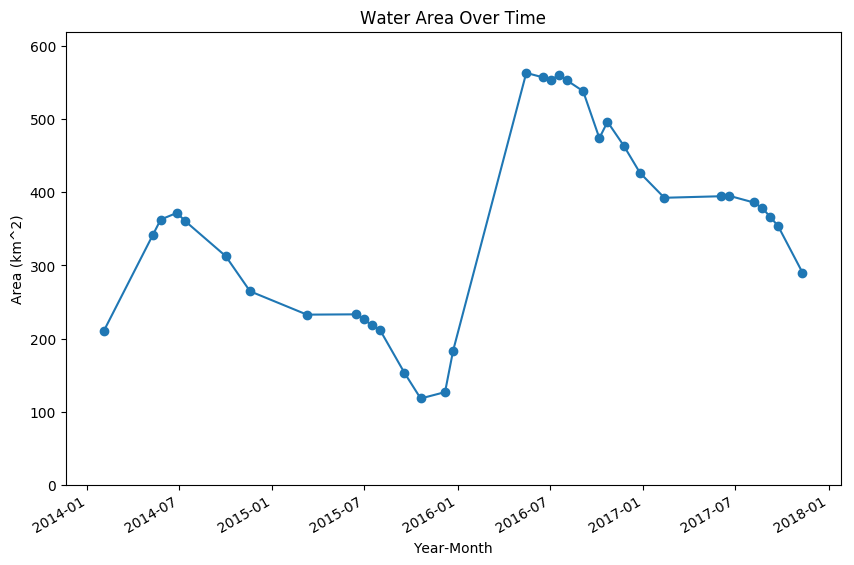

In [19]:
figsize = (10, 6) # The width and height of the figure, respectively.
fig = plt.figure(figsize=figsize, dpi=100)

# Show only some of the times to avoid cluttering the figure with tick labels.
plotting_data = water_da.astype(np.uint8).to_dataset('Area (km^2)') * np.prod(km_per_px)
water_area_da = plotting_data.sum(['latitude', 'longitude'])['Area (km^2)']
water_area_da.plot()
plt.ylim(0, water_area_da.max().values * 1.1)
plt.scatter(water_area_da.time.values, water_area_da)
plt.title("Water Area Over Time")
plt.xlabel('Year-Month')
plt.show()

<a id="contributors_heritage"></a>
## Contributors, Heritage and References [&#9652;](#top)
The notebooks liked here have been created by Brian Killough (NASA, CEOS Systems Engineering Office) in collaboration with a number of Open Data Cube (ODC) users from the Africian Regional Data Cube, Digital Earth Australia, and other ODC users globally.

GitHub repositories referenced/forked:

- https://github.com/ceos-seo/data_cube_utilities <i>A set of utilities maintained by the CEOS SEO team in support of the Notebooks being developed.</i>
- https://github.com/ceos-seo/data_cube_notebooks <i>A set of Notebooks maintained by the CEOS SEO team.</i>
- https://github.com/GeoscienceAustralia/dea-notebooks <i>Forked this repo to include / adapt the [Beginers_guide](https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Beginners_guide) Notebooks. Basis for adaptation was [George Dyke's fork](https://github.com/gamedaygeorge/dea-notebooks).</i>

Last updated June 2020.

[Back to top](#top)